In [1]:
#######################
# Dated: 28.07.2021
# Author: SH
# With Functions Allain Variance Wilcoxon_ Compparision T
#######################

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

#######################
#Importing data
#######################

#Calculates Allan variance from Wilcoxon accelerometer data and estimates
#interferometer sensitivity.
# The PSD is already calculated in Matt's code and is included in this CSV
# columns Freq_Hz Accel_g Accel_main

accel_matrix = pd.read_csv('10_5_21_ITE_ASD.csv')
accData=accel_matrix.values.tolist()
accData=np.asarray([np.asarray(elem) for elem in accData])
accel_matrix['freq'] = accel_matrix['Freq_Hz']
accel_matrix['raw_data_g'] = accel_matrix['Accel_g']
accel_matrix['psd_g'] = accel_matrix['Accel_main']


#corresponding columns and ararays
freq = np.array(accel_matrix['freq']) #Hz
raw_data_g = np.array(accel_matrix['raw_data_g']) #g
psd_g = np.array(accel_matrix['psd_g']) #g/sqrt(Hz)


#% Converting to different units for convenience
raw_data_gal = raw_data_g*980;  # 1 m/s^2 = 100 gal
psd_g_si = psd_g*9.8;# in m/s^21
psd_g_gal = psd_g*980;# in gal



In [2]:
#######################
# #COnstants
#######################
Omg=40*1e3 #Rabi frequency, Hz        ours is 4e4
tau=(1/(2*Omg)) #pi pulse length, s
T=20e-3 # interferometer time T, s      ours is 20e-3 max
wavelength = 780e-9
keff=4*np.pi/wavelength
Tc = 6; # cycle rep rate, s
fc = 1/Tc;

#######################
# Transfer function
#######################
freqArr=freq
testArr=psd_g

HH=(4*2*np.pi*freqArr*2*np.pi*Omg/((2*np.pi*freqArr)**2-(2*np.pi*Omg)**2))*np.sin(2*np.pi*(freqArr)*(T+tau)/2)*(np.cos(2*np.pi*freqArr*(T+tau)/2.)+((2*np.pi*Omg)/(2*np.pi*freqArr))*np.sin(2*np.pi*freqArr*T/2.))
HH_sq=HH*HH
HH_a_sq=keff**2/(2*np.pi*freqArr)**4*np.abs(HH_sq)# transfer function squared
HH_a_0_sq =keff**2/(2*np.pi*freqArr[1])**4*np.abs(HH_sq) # H(0) is undefined, so taking the smallest non-zero frequency and normalising to that
HH_a_norm = HH_a_sq/(HH_a_sq[1])# Normalised transfer function
acc_trans = HH_a_norm*psd_g_si# Applying the transfer function to the acceleration profile
# This should show how the interferometer itself filters acceleration noise

# Phase noise
S_phi = (keff**2) / (freqArr**4) * psd_g_si # I don't use this for anything, can ignore



<ipython-input-2-750d5508725b>:18: RuntimeWarning: divide by zero encountered in true_divide
  HH=(4*2*np.pi*freqArr*2*np.pi*Omg/((2*np.pi*freqArr)**2-(2*np.pi*Omg)**2))*np.sin(2*np.pi*(freqArr)*(T+tau)/2)*(np.cos(2*np.pi*freqArr*(T+tau)/2.)+((2*np.pi*Omg)/(2*np.pi*freqArr))*np.sin(2*np.pi*freqArr*T/2.))
<ipython-input-2-750d5508725b>:18: RuntimeWarning: invalid value encountered in multiply
  HH=(4*2*np.pi*freqArr*2*np.pi*Omg/((2*np.pi*freqArr)**2-(2*np.pi*Omg)**2))*np.sin(2*np.pi*(freqArr)*(T+tau)/2)*(np.cos(2*np.pi*freqArr*(T+tau)/2.)+((2*np.pi*Omg)/(2*np.pi*freqArr))*np.sin(2*np.pi*freqArr*T/2.))
<ipython-input-2-750d5508725b>:20: RuntimeWarning: divide by zero encountered in true_divide
  HH_a_sq=keff**2/(2*np.pi*freqArr)**4*np.abs(HH_sq)# transfer function squared
<ipython-input-2-750d5508725b>:27: RuntimeWarning: divide by zero encountered in true_divide
  S_phi = (keff**2) / (freqArr**4) * psd_g_si # I don't use this for anything, can ignore


In [3]:
#######################
# Allan variance
#######################
Tc = 1
fc = 1/Tc
mm = 10000   # total number of repetitions of the experiment
total_time = mm*Tc; # total integration time
#tt = 1:1:mm;    # number of measurement cycles    
tt = np.linspace(1,mm,mm)

# Sampling the transfer function and acceleration PSD.
# This follows equation 2.68 from Rosi.
# For the acceleration PSD data, we have to sample the spectrum in steps of
# fc. In the code below, I set up the frequency sample points that I want,
# then use the "find" function to grab the closest frequency to the one I
# want, since the accelerometer data won't have the exact frequency.

max_nn = int(np.round(max(freq)/fc))#;   % Total number of frequency points
freq_sample_points = np.linspace(np.min(freq),np.max(freq),max_nn+1)#;  % Need to sample our measured PSD, so have to pick out the frequencies

# Loop through each multple of fc and grab the index of the nearest
# frequency in the data.
# We are looking for frequencies that fall in a window of +/- fc/30. In
# case of multiple results, we just grab the first result that's found.
# If Tc is reduced, then we must decrease the window size. Eg. Tc = 1 s
# needs +/-fc/195 in order to retrieve sensible results.

x = np.linspace(0,max_nn,max_nn+1)
freq_index=0.0*x
for yau in x:
    #print(freq_sample_points[x==yau])
    #print(np.where((freq > (freq_sample_points[x==yau] - fc/30)) & (freq < (freq_sample_points[x==yau] + fc/30)))[0][0])
    freq_index[x==yau] = np.where((freq > (freq_sample_points[x==yau] - fc/30)) & (freq < (freq_sample_points[x==yau] + fc/30)))[0][0]
    #print(freq_index[x==yau])
    
nn = np.linspace(1,max_nn+1,max_nn+1)

In [4]:
#######################
# Function Declaration and Definition
#######################
def calc_variance(t):
    T = t
    #% Now we use Rosi equation 2.68:
    HH_nn = ( 4*2*np.pi*nn*fc*2*np.pi*Omg / ((2*np.pi*nn*fc)**2 - (2*np.pi*Omg)**2) ) * np.sin(2*np.pi*nn*fc*(T + tau)/2) * ( np.cos(2*np.pi*nn*fc*(T + tau)/2) + (2*np.pi*Omg/(2*np.pi*nn*fc))*np.sin(2*np.pi*nn*fc*T/2))

    HH_nn_sq = np.abs(HH_nn)**2;
    HH_total = HH_nn_sq / (2*np.pi*nn*fc)**4;

    S_a = freq_index*0; # acceleration noise density at sampled frequency values
    x = np.linspace(0,max_nn,max_nn+1)
    freq_samples = freq_index*0;
    for wau in x:
        #print(freq_index[x==wau])
        #print(psd_g_si[int(freq_index[x==wau])])
        S_a[x==wau] = psd_g_si[int(freq_index[x==wau])]
        freq_samples[x==wau] = freq[int(freq_index[x==wau])]


    av_nn = HH_total*S_a
    av_sum = np.sum(av_nn);

    # Allan variance for acceleration, as per Freier thesis equation 2.16:
    av_g = (keff**2)/(tt*Tc) * av_sum / ((keff**2) * (T**4));
    return (av_g)

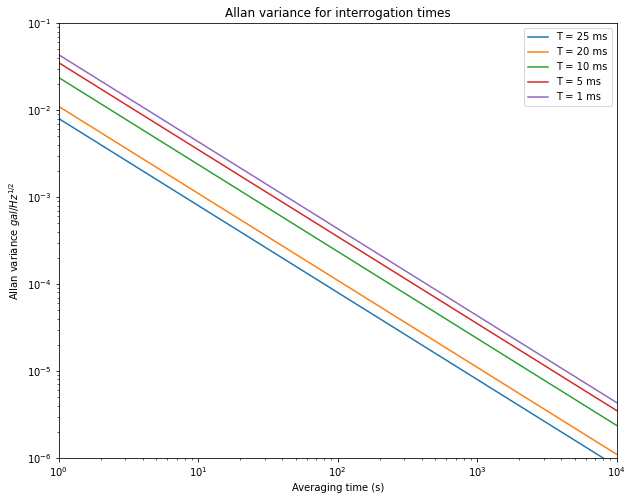

In [5]:
#######################
# Call function
#######################
T = 20e-3
av_g_20 = calc_variance(T);
#######################
#######################
T = 10e-3
av_g_10 = calc_variance(T);
#######################
#######################
T = 5e-3
av_g_5 = calc_variance(T);
#######################
#######################
T = 1e-3
av_g_1 = calc_variance(T);
#######################
#######################
T = 25e-3
av_g_25 = calc_variance(T);
#######################


#######################
#Figues
#######################
#loglog((1:1:mm)*Tc,av_g)

figure,ax=plt.subplots(figsize=(10, 8))
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(tt*Tc, av_g_25*100)
ax.plot(tt*Tc, av_g_20*100)
ax.plot(tt*Tc, av_g_10*100)
ax.plot(tt*Tc, av_g_5*100)
ax.plot(tt*Tc, av_g_1*100)

ax.set_xlabel(r'Averaging time (s)',fontsize=10)
ax.set_ylabel(r'Allan variance $gal/Hz^{1/2}$',fontsize=10)
ax.set_title('Allan variance for interrogation times')
plt.gca().legend(('T = 25 ms','T = 20 ms','T = 10 ms','T = 5 ms','T = 1 ms'))
ax.set_ylim(1e-6,1e-1)
ax.set_xlim(1e0,1e4)
plt.savefig('figure937.pdf')